In [1]:
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from fft_conv_pytorch import FFTConv2d
from PIL import Image
import glob
import math

In [2]:
filelist = glob.glob('../Dataset/*')
images = np.array([np.array(Image.open(fname)) for fname in filelist])

In [3]:
images.shape

(1836, 240, 240, 3)

In [4]:
images = (images-np.min(images))/(np.max(images)-np.min(images))

In [5]:
train_X, valid_X = train_test_split(images, test_size=0.2, random_state=42)

train_X = torch.tensor(train_X, dtype=torch.float32).permute(0, 3, 1, 2)
valid_X = torch.tensor(valid_X, dtype=torch.float32).permute(0, 3, 1, 2)

train_dataset = TensorDataset(train_X, train_X)
valid_dataset = TensorDataset(valid_X, valid_X)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class DCRBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DCRBlock, self).__init__()

        self.fft_conv1 = FFTConv2d(in_channels, out_channels,kernel_size=15, padding=7)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.fft_conv2 = FFTConv2d(in_channels + out_channels, out_channels,kernel_size=15, padding=7)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.fft_conv3 = FFTConv2d(in_channels + 2 * out_channels, out_channels,kernel_size=15, padding=7)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        c1 = self.bn1(self.fft_conv1(x))
        conca1 = torch.cat([x, c1], dim=1)

        c2 = self.bn2(self.fft_conv2(conca1))
        conca2 = torch.cat([x, c1, c2], dim=1)

        c3 = self.bn3(self.fft_conv3(conca2))

        if c3.size()[2:] != x.size()[2:]:
            c3 = torch.nn.functional.interpolate(c3, size=x.shape[2:])

        x = self.residual_conv(x)

        return x + c3


In [8]:
class UNetWithDCR(nn.Module):
    def __init__(self, in_channels, out_channels, base_channels):
        super(UNetWithDCR, self).__init__()

        self.enc1 = DCRBlock(in_channels, base_channels)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DCRBlock(base_channels, base_channels * 2)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DCRBlock(base_channels * 2, base_channels * 4)
        self.pool3 = nn.MaxPool2d(2)

        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec3 = DCRBlock(base_channels * 4 + base_channels * 4, base_channels * 2)

        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = DCRBlock(base_channels * 2 + base_channels * 2, base_channels)

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = DCRBlock(base_channels + base_channels, base_channels)

        self.final_conv = FFTConv2d(base_channels, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        up3 = self.up3(p3)
        d3 = self.dec3(torch.cat([up3, e3], dim=1))

        up2 = self.up2(d3)
        d2 = self.dec2(torch.cat([up2, e2], dim=1))

        up1 = self.up1(d2)
        d1 = self.dec1(torch.cat([up1, e1], dim=1))

        return self.final_conv(d1)

In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            del inputs, targets, outputs
            torch.cuda.empty_cache()

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}")
        torch.cuda.empty_cache()

In [10]:
model = UNetWithDCR(in_channels=3, out_channels=1, base_channels=4).to(device)
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
# Train the Model
train(model, train_loader, valid_loader, optimizer, criterion, epochs=25)

# Save Model
torch.save(model.state_dict(), 'FFC-DCR-UNET.pth')

C:\Users\skabi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([4, 3, 240, 240])) that is different to the input size (torch.Size([4, 1, 240, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 0.023178128482474455
Epoch 2, Train Loss: 0.0021647151194167723
Epoch 3, Train Loss: 0.0010545028923003243
Epoch 4, Train Loss: 0.0005605603263419051
Epoch 5, Train Loss: 0.0004041792593956817
Epoch 6, Train Loss: 0.00031922833748056006
Epoch 7, Train Loss: 0.00023759094037021045
Epoch 8, Train Loss: 0.00018480724611683836
Epoch 9, Train Loss: 0.00016754179548588978
Epoch 10, Train Loss: 0.00014625435382339616
Epoch 11, Train Loss: 0.00013305274596215488
Epoch 12, Train Loss: 0.00011736758954721055
Epoch 13, Train Loss: 0.00010248418013549858
Epoch 14, Train Loss: 9.814086470264097e-05
Epoch 15, Train Loss: 9.35561749766359e-05
Epoch 16, Train Loss: 8.289253784330655e-05
Epoch 17, Train Loss: 7.899081722761508e-05
Epoch 18, Train Loss: 7.396285304350649e-05
Epoch 19, Train Loss: 6.781184226615341e-05
Epoch 20, Train Loss: 6.478190596257318e-05
Epoch 21, Train Loss: 6.448489234348716e-05
Epoch 22, Train Loss: 5.5825739485153364e-05
Epoch 23, Train Loss: 5.9336301293

In [ ]:
model.load_state_dict(torch.load('FFC-DCR-UNET.pth'))
model.eval()

with torch.no_grad():
    inputs, _ = next(iter(valid_loader))
    inputs = inputs.to(device)
    outputs = model(inputs).cpu().numpy()

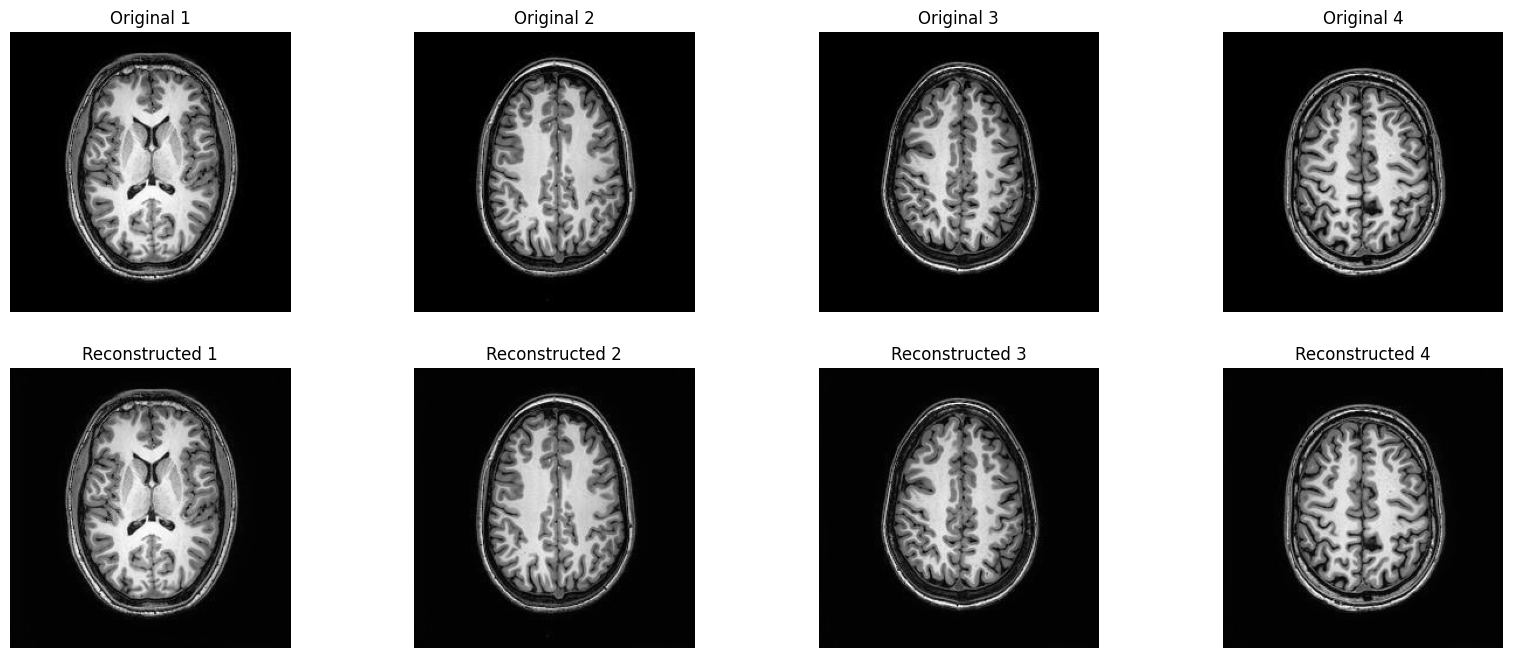

In [ ]:
plt.figure(figsize=(20, 8))
batch_size = inputs.shape[0]

for i in range(batch_size):
    plt.subplot(2, batch_size, i + 1)
    plt.imshow(inputs[i].cpu().numpy().transpose(1, 2, 0), cmap='gray')

    plt.title(f"Original {i+1}")
    plt.axis('off')

    plt.subplot(2, batch_size, i + 1 + batch_size)
    plt.imshow(outputs[i, 0], cmap='gray')
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.show()

In [ ]:
[a, b, c, d] = valid_X.shape
mean = 0
sigma = 0.1
gauss = np.random.normal(mean, sigma, (a, b, c, d))

if isinstance(valid_X, torch.Tensor):
    valid_X = valid_X.cpu().numpy()

noisy_images = valid_X + gauss

with torch.no_grad():
    noisy_inputs = torch.from_numpy(noisy_images[:5]).float().to(device)

    pred_noisy = model(noisy_inputs).cpu().numpy()

pred_noisy = np.clip(pred_noisy, 0, 1)

Noisy Test Images and Reconstructions


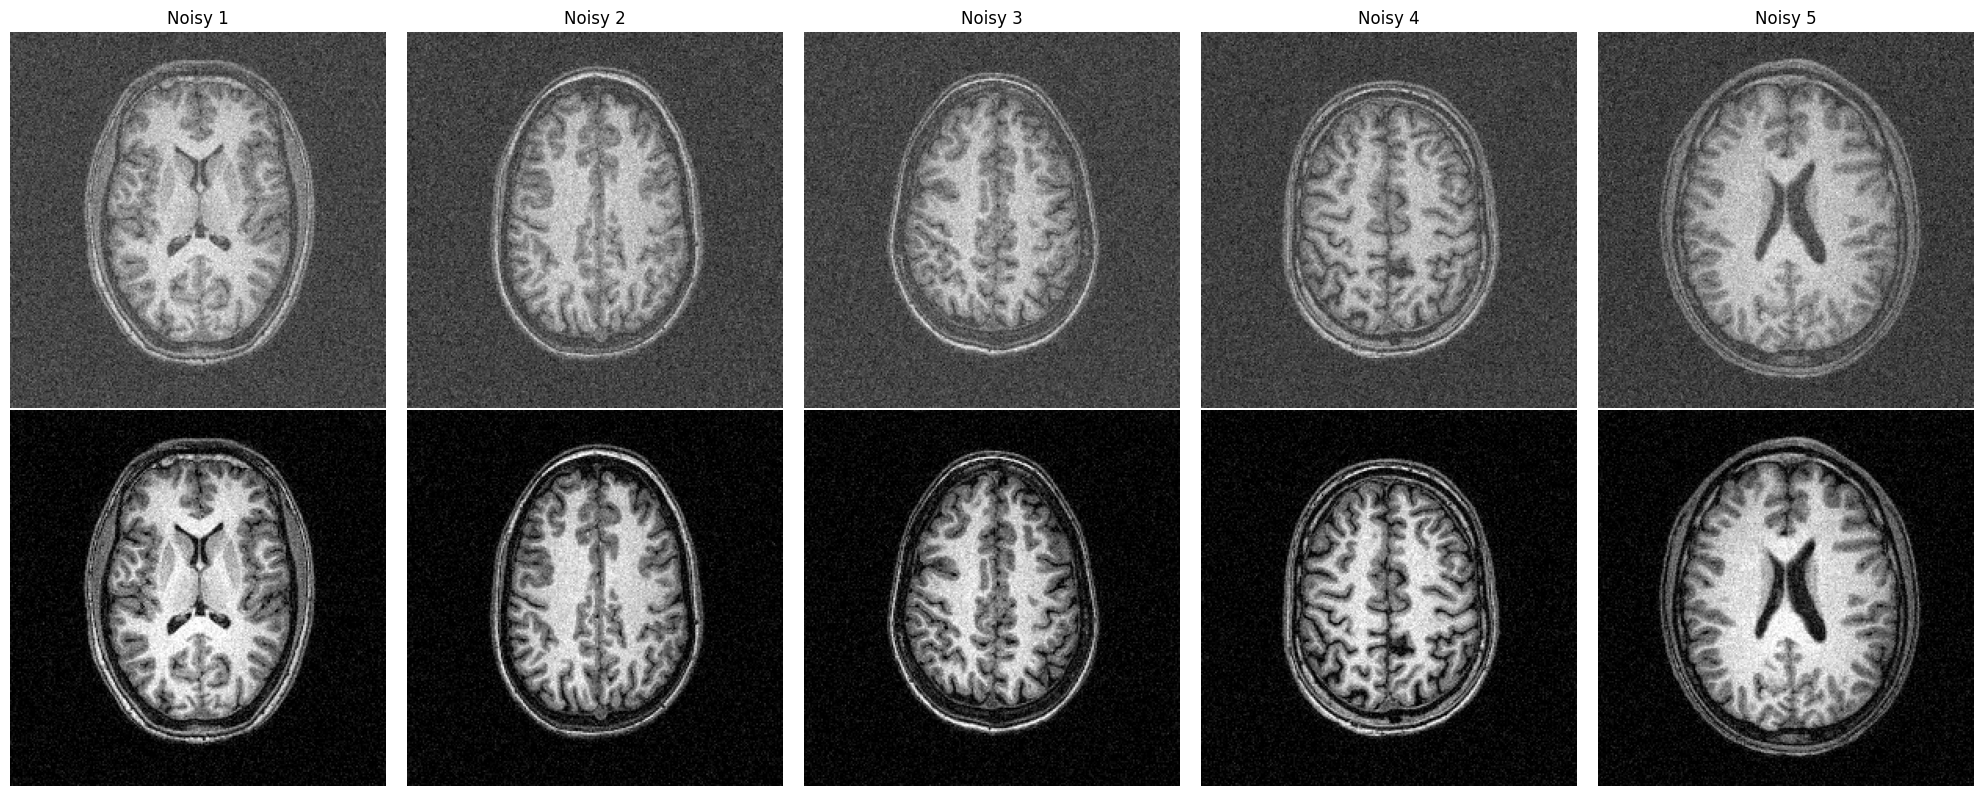

In [ ]:
plt.figure(figsize=(20, 8))
print("Noisy Test Images and Reconstructions")

for i in range(5):
    plt.subplot(2, 5, i + 1)
    image = noisy_images[i]
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Noisy {i + 1}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    pred_image = pred_noisy[i]
    plt.imshow(pred_image[0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import time
from skimage.metrics import structural_similarity as ssim

def benchmark_inference(model, data_loader, device):
    model.eval()
    total_time = 0
    total_images = 0
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = time.time()
            _ = model(inputs)
            total_time += time.time() - start_time
            total_images += inputs.size(0)
    return total_time / total_images

def compute_quality_metrics(valid_X, pred_X):
    if isinstance(valid_X, torch.Tensor):
        valid_X = valid_X.cpu().numpy()
    if isinstance(pred_X, torch.Tensor):
        pred_X = pred_X.cpu().numpy()

    N = min(valid_X.shape[0], pred_X.shape[0])
    valid_X = valid_X[:N]
    pred_X = pred_X[:N]

    if valid_X.shape[1] != pred_X.shape[1]:
        valid_X = valid_X[:, 0:1, :, :]
        pred_X = pred_X[:, 0:1, :, :]

    mse = np.mean((valid_X - pred_X) ** 2)
    psnr = 20 * np.log10(1 / np.sqrt(mse))
    ssim_values = [ssim(valid_X[i, 0], pred_X[i, 0], data_range=1.0) for i in range(N)]
    avg_ssim = np.mean(ssim_values)
    return mse, psnr, avg_ssim

inference_time = benchmark_inference(model, valid_loader, device)


mse, psnr, avg_ssim = compute_quality_metrics(valid_X, pred_noisy)


print(f"MSE: {mse:.4f}")
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {avg_ssim:.3f}")
print(f"Inference Time per Image: {inference_time:.4f} seconds")

MSE: 0.0024
PSNR: 26.12 dB
SSIM: 0.425
Inference Time per Image: 0.0092 seconds
